In [1]:
import sys
sys.path.insert(0, '../../')  

import math
import numpy as np
import numpy.typing as npt
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt 
from gasp import train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_simple, sampling, responses, SSFPParams

In [2]:
def compute_condition_number(I):
    I = I.reshape((-1, I.shape[-1]))    # Collapse all dimensions last dimension
    return np.linalg.cond(I)            # Compute condition number

def run_model(D, params, T2base = 0.01, T1T2ratio = 5.0):
    width = 256
    height = 1
    gradient = 2 * np.pi
    method = 'affine'

    M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2 = T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
    C = compute_condition_number(M)
    U, s, Vt = np.linalg.svd(M, full_matrices=False)
    R = matrix_rank(M)
    _, A = train_gasp(M, D, method=method)
    I = run_gasp(M, A, method=method)
    MSE = np.sqrt(np.mean((np.abs(I) - D)**2))

    return A, I, MSE, C, U, s, Vt, R

def test_model(A, D, params, T2base = 0.01, T1T2ratio = 5.0):
    width = 256
    height = 1
    gradient = 2 * np.pi
    method = 'affine'

    M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2 = T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
    I = run_gasp(M, A, method=method)
    MSE = np.sqrt(np.mean((np.abs(I) - D)**2))

    return I, MSE

0.10471975511965978 [0.005, 0.01, 0.02] 12
1.5707963267948966 [0.005, 0.01, 0.02] 12
0.02564600348550602 24229.433862695405 [24]
0.02564600348550602 24229.433862695405 [24]
0.02564600348550602 24229.433862695405 [24]
0.02564600348550602 24229.433862695405 [24]


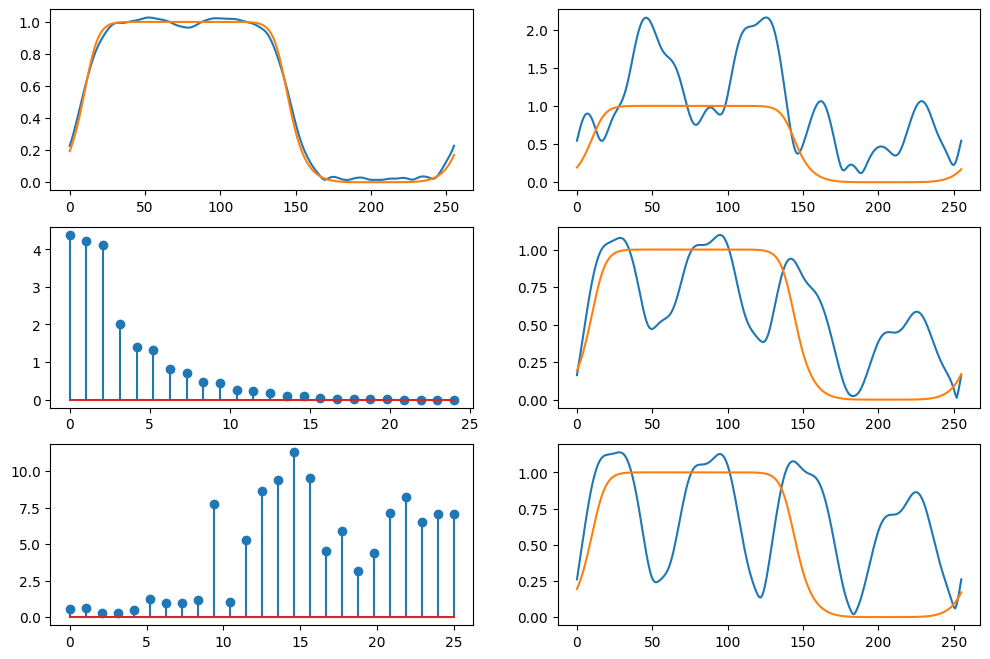

In [17]:
def grid_3d_sampling(n_points, alphas, TRs):
    n = n_points // len(alphas)

    TR = []
    PC = []
    alpha = []
    for value in alphas:
        print(value, TRs, n)
        _TRs, _PCs = sampling.grid_TR_sampling(n_points=n, TRs=TRs)
        _alpha = np.ones(n) * value

        TR.append(list(_TRs))
        PC.append(list(_PCs))
        alpha.append(_alpha)

    return SSFPParams(n_points, alpha, TR, PC)

n = 24
width = 256
alpha = np.deg2rad(40)
T1T2ratio = 5

D = responses.bandpass_filter(width, bw=0.25, shift=-0.2)
#D = responses.square(width, 0.2, 0)
#D = responses.gaussian(width, 0.5, 0)

params = grid_3d_sampling(n_points=n, alphas=[np.deg2rad(6), np.deg2rad(90)], TRs=[5e-3, 10e-3, 20e-3])
#print(params.alpha, params.TRs, params.pcs)
A, I, MSE, C, U, s, Vt, R = run_model(D, params, T1T2ratio=5)
print(MSE, C, R)

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs[0,0].plot(np.abs(I[0]))
axs[0,0].plot(D)
x = np.linspace(0, n, n)
axs[1,0].stem(x, s[0])
x = np.linspace(0, n+1, n+1)
axs[2,0].stem(x, np.abs(A))

I1, MSE1 = test_model(A, D, params, T1T2ratio=2.5)
print(MSE, C, R)

I2, MSE2 = test_model(A, D, params, T1T2ratio=10)
print(MSE, C, R)

I3, MSE3 = test_model(A, D, params, T1T2ratio=18)
print(MSE, C, R)

axs[0,1].plot(np.abs(I1[0]))
axs[0,1].plot(D)
x = np.linspace(0, n, n)
axs[1,1].plot(np.abs(I2[0]))
axs[1,1].plot(D)
x = np.linspace(0, n+1, n+1)
axs[2,1].plot(np.abs(I3[0]))
axs[2,1].plot(D)
plt.show()